In [45]:
# Import libraries
import pandas as pd
import duckdb as db
from duckdb.duckdb import DuckDBPyConnection

# Import custom functions
from generate import generate_continuous_sensors_event_data
from visualise import plot_sensor_data

In [4]:
# Generate a CSV file of sensor data
generate_continuous_sensors_event_data()

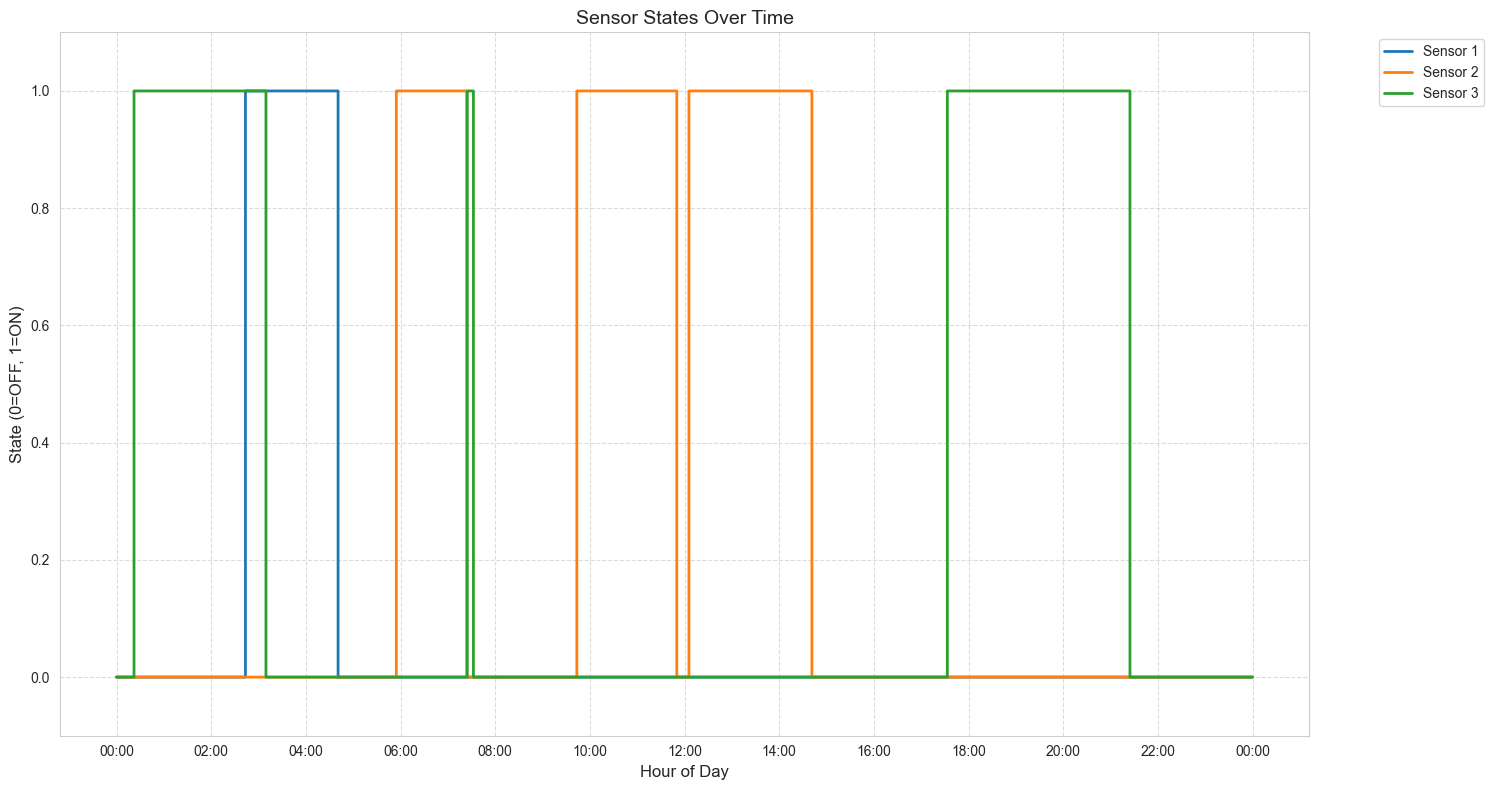

In [46]:
# Read the sensor data CSV file and create a column plot
df = pd.read_csv("sensor_data.csv")
plot_sensor_data(df)

In [47]:
# Create an in-memory connection to a DuckDB database
con = db.connect()

In [48]:
# Create a table of the sensor data to query
con.execute(
    "CREATE TABLE sensor_data AS SELECT * FROM READ_CSV_AUTO('sensor_data.csv')"
)

In [53]:
# Query the table to view the first 10 rows
con.sql("SELECT * FROM sensor_data LIMIT 10").show()

┌─────────────────────┬───────────┬──────────────┐
│      timestamp      │ sensor_id │ sensor_value │
│      timestamp      │   int64   │    int64     │
├─────────────────────┼───────────┼──────────────┤
│ 2024-12-12 00:00:00 │         1 │            0 │
│ 2024-12-12 00:00:00 │         2 │            0 │
│ 2024-12-12 00:00:00 │         3 │            0 │
│ 2024-12-12 00:00:05 │         1 │            0 │
│ 2024-12-12 00:00:05 │         2 │            0 │
│ 2024-12-12 00:00:05 │         3 │            0 │
│ 2024-12-12 00:00:10 │         1 │            0 │
│ 2024-12-12 00:00:10 │         2 │            0 │
│ 2024-12-12 00:00:10 │         3 │            0 │
│ 2024-12-12 00:00:15 │         1 │            0 │
├─────────────────────┴───────────┴──────────────┤
│ 10 rows                              3 columns │
└────────────────────────────────────────────────┘



In [54]:
# Count the rows in the table
con.sql("SELECT COUNT(*) AS total_records FROM sensor_data").show()

┌───────────────┐
│ total_records │
│     int64     │
├───────────────┤
│         51843 │
└───────────────┘



In [51]:
# Create a simple demo sample
demo_sensor_data = {
    "sensor_id": [1] * 10,
    "timestamp": [
        "2024-12-18 00:00:00",
        "2024-12-18 01:00:00",
        "2024-12-18 02:00:00",
        "2024-12-18 03:00:00",
        "2024-12-18 04:00:00",
        "2024-12-18 05:00:00",
        "2024-12-18 06:00:00",
        "2024-12-18 07:00:00",
        "2024-12-18 08:00:00",
        "2024-12-18 09:00:00",
    ],
    "sensor_value": [0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
}

# Create a DataFrame from the sample data and display it, parsing timestamp as datetime
demo_sensor_data_df = pd.DataFrame(demo_sensor_data)

# Data types
data_types = {
    "sensor_id": int,
    "timestamp": "datetime64[ns]",
    "sensor_value": int,
}

# Cast the types of the columns using
demo_sensor_data_df = demo_sensor_data_df.astype(data_types)

# Adjust index to start from 1 to align with SQL row numbering
demo_sensor_data_df.index += 1

# Display the DataFrame
demo_sensor_data_df

,sensor_id,timestamp,sensor_value
1,1,2024-12-18 00:00:00,0
2,1,2024-12-18 01:00:00,1
3,1,2024-12-18 02:00:00,1
4,1,2024-12-18 03:00:00,0
5,1,2024-12-18 04:00:00,1
6,1,2024-12-18 05:00:00,1
7,1,2024-12-18 06:00:00,0
8,1,2024-12-18 07:00:00,0
9,1,2024-12-18 08:00:00,1
10,1,2024-12-18 09:00:00,1


In [55]:
# Use window function to solve the gaps and islands problem with CTEs,
# the sensor_id, event_start_timestamp and event_end_timestamp columns will be returned

con.sql(
    """
-- Create a row number for each sensor_id in ascending order of timestamp
WITH sensor_data_with_row_number AS (
    SELECT
        *,
        ROW_NUMBER() OVER (
            PARTITION BY sensor_id
            ORDER BY
                timestamp
        ) AS row_id
    FROM
        demo_sensor_data_df
),
-- Create an island_id for each sensor_id where the sensor_value is 1
sensor_data_with_island_id AS (
    SELECT
        *,
        ROW_NUMBER() OVER(ORDER BY TIMESTAMP) AS partitioned_row_id,
        row_id - ROW_NUMBER() OVER (
            PARTITION BY sensor_id
            ORDER BY
                timestamp
        ) AS island_id
    FROM
        sensor_data_with_row_number
    WHERE
        sensor_value = 1
)
-- Select the results from the final CTE
SELECT * FROM sensor_data_with_island_id;
    """
    ).show()

┌───────────┬─────────────────────┬──────────────┬────────┬────────────────────┬───────────┐
│ sensor_id │      timestamp      │ sensor_value │ row_id │ partitioned_row_id │ island_id │
│   int32   │    timestamp_ns     │    int32     │ int64  │       int64        │   int64   │
├───────────┼─────────────────────┼──────────────┼────────┼────────────────────┼───────────┤
│         1 │ 2024-12-18 01:00:00 │            1 │      2 │                  1 │         1 │
│         1 │ 2024-12-18 02:00:00 │            1 │      3 │                  2 │         1 │
│         1 │ 2024-12-18 04:00:00 │            1 │      5 │                  3 │         2 │
│         1 │ 2024-12-18 05:00:00 │            1 │      6 │                  4 │         2 │
│         1 │ 2024-12-18 08:00:00 │            1 │      9 │                  5 │         4 │
│         1 │ 2024-12-18 09:00:00 │            1 │     10 │                  6 │         4 │
└───────────┴─────────────────────┴──────────────┴────────┴───────────

In [56]:
# Create a function to output the sensor events as a table using this logic,
# and test on the sensor data table created earlier


def get_events(con: DuckDBPyConnection, data_table_name: str, event_table_name) -> None:
    con.execute(
        f"""
-- Create new table to store the sensor events aggreegated via the CTEs
CREATE OR REPLACE TABLE {event_table_name} AS

    -- Create a row number for each sensor_id in ascending order of timestamp
    WITH sensor_data_with_row_number AS (
        SELECT
            *,
            ROW_NUMBER() OVER (
                PARTITION BY sensor_id
                ORDER BY
                    timestamp
            ) AS row_id
        FROM
            {data_table_name}
    ),
    -- Create an island_id for each sensor_id where the sensor_value is 1
    sensor_data_with_island_id AS (
        SELECT
            *,
            row_id - ROW_NUMBER() OVER (
                PARTITION BY sensor_id
                ORDER BY
                    timestamp
            ) AS island_id
        FROM
            sensor_data_with_row_number
        WHERE
            sensor_value = 1
    ),
    -- Aggregate the sensor data by sensor_id and island_id to get the
    -- event_start_timestamp, event_end_timestamp and event_duration
    sensor_data_event_agg AS (
        SELECT
            sensor_id,
            MIN(timestamp) AS event_start_timestamp,
            MAX(timestamp) AS event_end_timestamp,
            event_end_timestamp - event_start_timestamp AS event_duration
        FROM
            sensor_data_with_island_id
        GROUP BY
            sensor_id,
            island_id
        ORDER BY
            sensor_id,
            event_start_timestamp
    )

-- Populate the {event_table_name} table with the aggregated data from final CTE
SELECT * FROM sensor_data_event_agg;
    """
    )


# Name the table to process data from, and the event table to output the results to
data_table_name = "sensor_data"
event_table_name = "sensor_events"

# Call the function to get the sensor events
get_events(con, data_table_name, event_table_name)

# Output the sensor events table
con.sql(f"SELECT * FROM {event_table_name}").show()

┌───────────┬───────────────────────┬─────────────────────┬────────────────┐
│ sensor_id │ event_start_timestamp │ event_end_timestamp │ event_duration │
│   int64   │       timestamp       │      timestamp      │    interval    │
├───────────┼───────────────────────┼─────────────────────┼────────────────┤
│         1 │ 2024-12-12 02:43:25   │ 2024-12-12 04:40:45 │ 01:57:20       │
│         2 │ 2024-12-12 05:54:40   │ 2024-12-12 07:23:45 │ 01:29:05       │
│         2 │ 2024-12-12 09:43:30   │ 2024-12-12 11:50:10 │ 02:06:40       │
│         2 │ 2024-12-12 12:05:35   │ 2024-12-12 14:41:25 │ 02:35:50       │
│         3 │ 2024-12-12 00:22:10   │ 2024-12-12 03:09:20 │ 02:47:10       │
│         3 │ 2024-12-12 07:24:40   │ 2024-12-12 07:32:20 │ 00:07:40       │
│         3 │ 2024-12-12 17:33:10   │ 2024-12-12 21:24:35 │ 03:51:25       │
└───────────┴───────────────────────┴─────────────────────┴────────────────┘



In [57]:
# Create a new table of sensor data, but where the timestamps that make up the
# first sensor_id have a gap of 60 seconds missing in the middle

con.execute(
    """
-- Create table to store the original sensor data with gap for first sensor_id = 1 event
CREATE OR REPLACE TABLE sensor_data_gap AS

    -- Get the start and end timestamps of the first sensor event
    WITH first_sensor_event AS (
        SELECT
            FIRST (event_start_timestamp) AS event_start_timestamp,
            FIRST (event_end_timestamp) AS event_end_timestamp
        FROM
            sensor_events
        WHERE
            sensor_id = 1
        GROUP BY
            sensor_id
    ),
    -- Get the median timestamp from the raw sensor data in this range
    median_data_timestamp AS (
        SELECT
            MEDIAN (timestamp) as median_timestamp,
        FROM
            sensor_data
        WHERE
            sensor_id = 1
            AND timestamp BETWEEN (
                SELECT
                    event_start_timestamp
                FROM
                    first_sensor_event
            )
            AND (
                SELECT
                    event_end_timestamp
                FROM
                    first_sensor_event
            )
    ),
    -- Get the min & max timestamps for the 30 second window around the median timestamp
    min_max_data_timestamps AS (
        SELECT
            median_timestamp - INTERVAL 30 SECONDS as min_timestamp,
            median_timestamp + INTERVAL 30 SECONDS as max_timestamp
        FROM
            median_data_timestamp
    ),
    -- Get data for all sensors excluding this 60 sec gap for first sensor_id = 1 event
    sensor_data_with_gap AS (
        SELECT
            *
        FROM
            sensor_data
        WHERE
            NOT (
                sensor_id = 1
                AND timestamp BETWEEN (
                    SELECT
                        min_timestamp
                    FROM
                        min_max_data_timestamps
                )
                AND (
                    SELECT
                        max_timestamp
                    FROM
                        min_max_data_timestamps
                )
            )
    )

-- Populate the sensor_data_gap table with the data excluding the 60 second gap
SELECT * FROM sensor_data_with_gap;
"""
)

In [58]:
# Now run again with timestamp gap in first sensor_id = 1 event

# Name the table to process data from, and the event table to output the results to
data_table_name = "sensor_data_gap"
event_table_name = "sensor_events_gap"

# Call the function to get the sensor events
get_events(con, data_table_name, event_table_name)

# Output the sensor events table
con.sql(f"SELECT * FROM {event_table_name}").show()

┌───────────┬───────────────────────┬─────────────────────┬────────────────┐
│ sensor_id │ event_start_timestamp │ event_end_timestamp │ event_duration │
│   int64   │       timestamp       │      timestamp      │    interval    │
├───────────┼───────────────────────┼─────────────────────┼────────────────┤
│         1 │ 2024-12-12 02:43:25   │ 2024-12-12 04:40:45 │ 01:57:20       │
│         2 │ 2024-12-12 05:54:40   │ 2024-12-12 07:23:45 │ 01:29:05       │
│         2 │ 2024-12-12 09:43:30   │ 2024-12-12 11:50:10 │ 02:06:40       │
│         2 │ 2024-12-12 12:05:35   │ 2024-12-12 14:41:25 │ 02:35:50       │
│         3 │ 2024-12-12 00:22:10   │ 2024-12-12 03:09:20 │ 02:47:10       │
│         3 │ 2024-12-12 07:24:40   │ 2024-12-12 07:32:20 │ 00:07:40       │
│         3 │ 2024-12-12 17:33:10   │ 2024-12-12 21:24:35 │ 03:51:25       │
└───────────┴───────────────────────┴─────────────────────┴────────────────┘



In [59]:
# Create a new get events query that will only group events where there is no gap
# larger than 60 minutes between the timestamps

con.sql(
    """
    -- Calculate time difference to previous timestamp by sensor_id
    WITH sensor_data_with_time_diff AS (
        SELECT
            *,
            timestamp - LAG(timestamp) OVER (
                PARTITION BY sensor_id
                ORDER BY
                    timestamp
            ) AS time_since_last_timestamp
        FROM
            demo_sensor_data_df
        WHERE
            sensor_value = 1
    ),
    -- Create a unique event group identifier
    sensor_data_with_event_group AS (
        SELECT
            *,
            SUM(
                CASE
                    WHEN time_since_last_timestamp > INTERVAL '60 min'
                    OR time_since_last_timestamp IS NULL THEN 1
                    ELSE 0
                END
            ) OVER (
                PARTITION BY sensor_id
                ORDER BY
                    timestamp
            ) AS event_group
        FROM
            sensor_data_with_time_diff
    )

-- Populate the event table with the aggregated data from final CTE
SELECT * FROM sensor_data_with_event_group;
    """
    ).show()

┌───────────┬─────────────────────┬──────────────┬───────────────────────────┬─────────────┐
│ sensor_id │      timestamp      │ sensor_value │ time_since_last_timestamp │ event_group │
│   int32   │    timestamp_ns     │    int32     │         interval          │   int128    │
├───────────┼─────────────────────┼──────────────┼───────────────────────────┼─────────────┤
│         1 │ 2024-12-18 01:00:00 │            1 │ NULL                      │           1 │
│         1 │ 2024-12-18 02:00:00 │            1 │ 01:00:00                  │           1 │
│         1 │ 2024-12-18 04:00:00 │            1 │ 02:00:00                  │           2 │
│         1 │ 2024-12-18 05:00:00 │            1 │ 01:00:00                  │           2 │
│         1 │ 2024-12-18 08:00:00 │            1 │ 03:00:00                  │           3 │
│         1 │ 2024-12-18 09:00:00 │            1 │ 01:00:00                  │           3 │
└───────────┴─────────────────────┴──────────────┴────────────────────

In [61]:
# Create a new get events function that will only group events where there is no gap
# larger than max_gap_sec seconds between the timestamps


def get_events_no_gap(
    con: DuckDBPyConnection,
    data_table_name: str,
    event_table_name: str,
    max_gap_sec: int = 30,
) -> None:
    con.execute(
        f"""
-- Create new table to store the sensor events aggregated via the CTEs
CREATE OR REPLACE TABLE {event_table_name} AS

    -- Calculate time difference to previous timestamp by sensor_id
    WITH sensor_data_with_time_diff AS (
        SELECT
            *,
            timestamp - LAG(timestamp) OVER (
                PARTITION BY sensor_id
                ORDER BY
                    timestamp
            ) AS time_since_last_timestamp
        FROM
            {data_table_name}
        WHERE
            sensor_value = 1
    ),
    -- Create a unique event group identifier
    sensor_data_with_event_group AS (
        SELECT
            *,
            SUM(
                CASE
                    WHEN time_since_last_timestamp > INTERVAL '{max_gap_sec} sec'
                    OR time_since_last_timestamp IS NULL THEN 1
                    ELSE 0
                END
            ) OVER (
                PARTITION BY sensor_id
                ORDER BY
                    timestamp
            ) AS event_group
        FROM
            sensor_data_with_time_diff
    ),
    -- Aggregate the sensor data by sensor_id and event_group
    sensor_data_event_agg AS (
        SELECT
            sensor_id,
            MIN(timestamp) AS event_start_timestamp,
            MAX(timestamp) AS event_end_timestamp,
            event_end_timestamp - event_start_timestamp AS event_duration
        FROM
            sensor_data_with_event_group
        GROUP BY
            sensor_id,
            event_group
        ORDER BY
            sensor_id,
            event_start_timestamp
    )

-- Populate the event table with the aggregated data from final CTE
SELECT * FROM sensor_data_event_agg;
    """
    )

In [62]:
# Now timestamps need to be within 30 secs of each other to be grouped in same event

# Name the table to process data from, and the event table to output the results to
data_table_name = "sensor_data_gap"
event_table_name = "sensor_events_no_gap"

# Call the function to get the sensor events
get_events_no_gap(con, data_table_name, event_table_name, max_gap_sec=30)

# Output the sensor events table
con.sql(f"SELECT * FROM {event_table_name}").show()

┌───────────┬───────────────────────┬─────────────────────┬────────────────┐
│ sensor_id │ event_start_timestamp │ event_end_timestamp │ event_duration │
│   int64   │       timestamp       │      timestamp      │    interval    │
├───────────┼───────────────────────┼─────────────────────┼────────────────┤
│         1 │ 2024-12-12 02:43:25   │ 2024-12-12 03:41:30 │ 00:58:05       │
│         1 │ 2024-12-12 03:42:40   │ 2024-12-12 04:40:45 │ 00:58:05       │
│         2 │ 2024-12-12 05:54:40   │ 2024-12-12 07:23:45 │ 01:29:05       │
│         2 │ 2024-12-12 09:43:30   │ 2024-12-12 11:50:10 │ 02:06:40       │
│         2 │ 2024-12-12 12:05:35   │ 2024-12-12 14:41:25 │ 02:35:50       │
│         3 │ 2024-12-12 00:22:10   │ 2024-12-12 03:09:20 │ 02:47:10       │
│         3 │ 2024-12-12 07:24:40   │ 2024-12-12 07:32:20 │ 00:07:40       │
│         3 │ 2024-12-12 17:33:10   │ 2024-12-12 21:24:35 │ 03:51:25       │
└───────────┴───────────────────────┴─────────────────────┴────────────────┘

In [63]:
# Now timestamps within 3 hours (30 * 60 * 60 secs) are grouped in the same event
data_table_name = "sensor_data_gap"
event_table_name = "sensor_events_gap_big"

# Call the function to get the sensor events
get_events_no_gap(con, data_table_name, event_table_name, max_gap_sec=3 * 60 * 60)

# Output the sensor events table
con.sql(f"SELECT * FROM {event_table_name}").show()

┌───────────┬───────────────────────┬─────────────────────┬────────────────┐
│ sensor_id │ event_start_timestamp │ event_end_timestamp │ event_duration │
│   int64   │       timestamp       │      timestamp      │    interval    │
├───────────┼───────────────────────┼─────────────────────┼────────────────┤
│         1 │ 2024-12-12 02:43:25   │ 2024-12-12 04:40:45 │ 01:57:20       │
│         2 │ 2024-12-12 05:54:40   │ 2024-12-12 14:41:25 │ 08:46:45       │
│         3 │ 2024-12-12 00:22:10   │ 2024-12-12 03:09:20 │ 02:47:10       │
│         3 │ 2024-12-12 07:24:40   │ 2024-12-12 07:32:20 │ 00:07:40       │
│         3 │ 2024-12-12 17:33:10   │ 2024-12-12 21:24:35 │ 03:51:25       │
└───────────┴───────────────────────┴─────────────────────┴────────────────┘

